
# Q9: Does the noise and anomalies in sensor readings provide any information?
    a. Find a model to detect anomalies in the data
    b. Analyze the anomalies to find any information

**Purpose of the question**: find the specific characteristics of the oil spots

In [1]:
import lasio
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from utils import *
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = lasio.read("./Data/16_10-2.las").df()
df.reset_index(inplace=True)
rename_columns(df)

In [3]:
# drop non numeric columns
Columns_to_drop = [
    My_Columns.FORMATION,
    My_Columns.GROUP,
    My_Columns.WELL,
    My_Columns.X_LOC,
    My_Columns.Y_LOC,
    My_Columns.Z_LOC,
    My_Columns.WELL,
    My_Columns.CONFIDENCE,
    My_Columns.SPECTRA_GAMMA_RAY,
    My_Columns.AVERAGE_RATE_OF_PENETRATION,
    My_Columns.MICRO_RESISTIVITY,
    My_Columns.WEIGHT_OF_DRILLING_MUD,
    My_Columns.FLUSHED_ZONE_RESISTIVITY,
    My_Columns.SHEAR_WAVE_SONIC,
    My_Columns.DIFFERENTIAL_CALIPER,
]

for column in Columns_to_drop:
    if column in df.columns:
        df.drop(column, axis=1, inplace=True)

df = df.dropna()
rename_lithology(df)
lithology_to_class(df)
df.describe()

,Measured Depth,LITHOLOGY,Caliper,Borehole Size,Density Correction,Thorium Concentration,Neutron Porosity,Bulk Density,Photo Electric Factor,Gamma Ray,Uranium Concentration,Compressional waves sonic,Deep Resistivity,Self Potential,Medium Deep Resistivity
count,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000
mean,2949.092383,2.315921,9.305946,8.819682,-0.005758,6.018291,0.263584,2.354949,8.269241,62.366173,2.738260,86.512455,0.994091,82.819437,1.563168
std,105.299848,3.173967,1.655215,1.047412,0.149452,2.926589,0.068046,0.143425,23.757667,51.234800,6.009244,11.602179,0.764765,22.309838,0.994849
min,2766.821777,0.000000,8.289063,8.500000,-1.106754,1.139225,0.056863,1.472794,2.894611,10.611666,-0.810094,57.601410,0.165527,33.177391,0.225675
25%,2857.957275,0.000000,8.304673,8.500000,0.004938,3.938173,0.224146,2.293692,4.503500,35.158291,0.406704,80.897957,0.562626,70.050362,1.094705
50%,2949.092285,0.000000,8.437500,8.500000,0.010862,5.523047,0.246645,2.367889,5.281301,49.184681,0.850750,84.200203,0.777824,89.418755,1.341802
75%,3040.227783,4.000000,9.500000,8.500000,0.022286,7.418532,0.277118,2.444588,6.389909,63.093781,1.408081,88.099861,1.231408,98.424652,1.675790
max,3131.362793,10.000000,18.123569,12.250001,0.149682,18.956129,0.501940,2.661118,998.892578,268.997192,28.493650,128.898804,5.082023,122.549301,15.835220


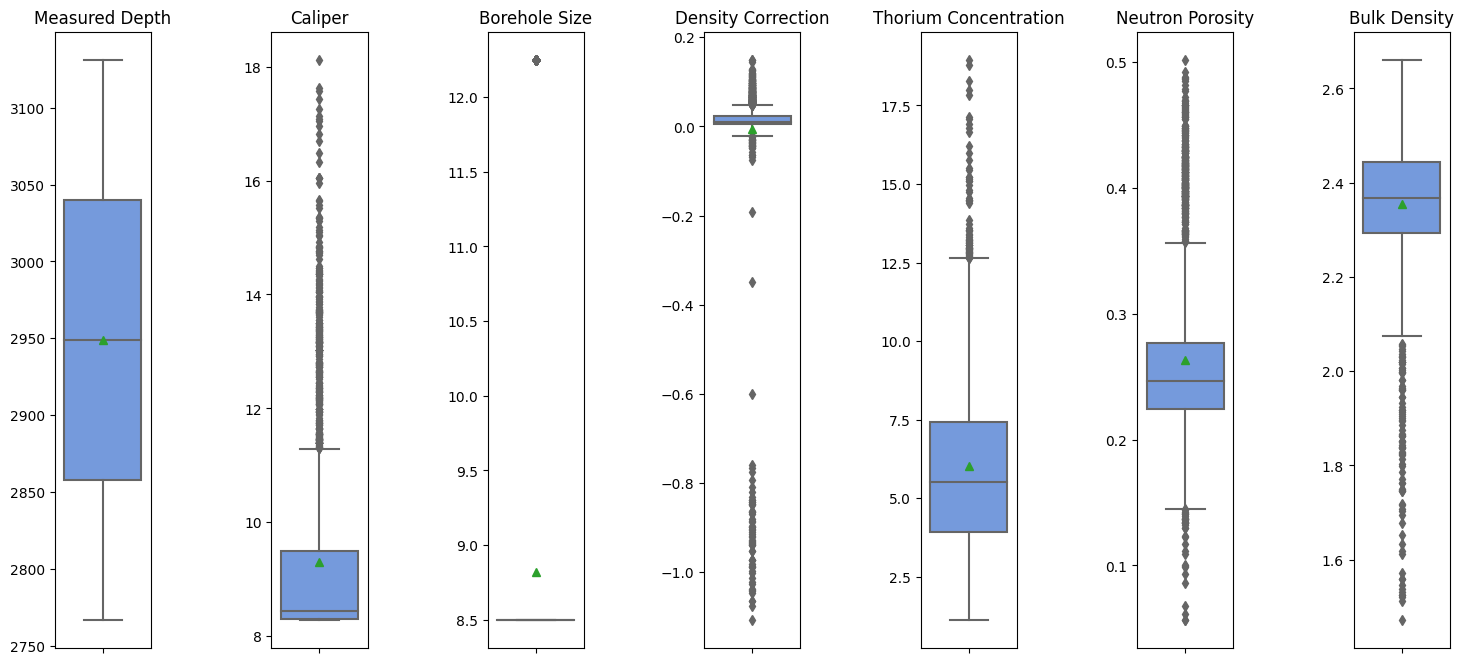

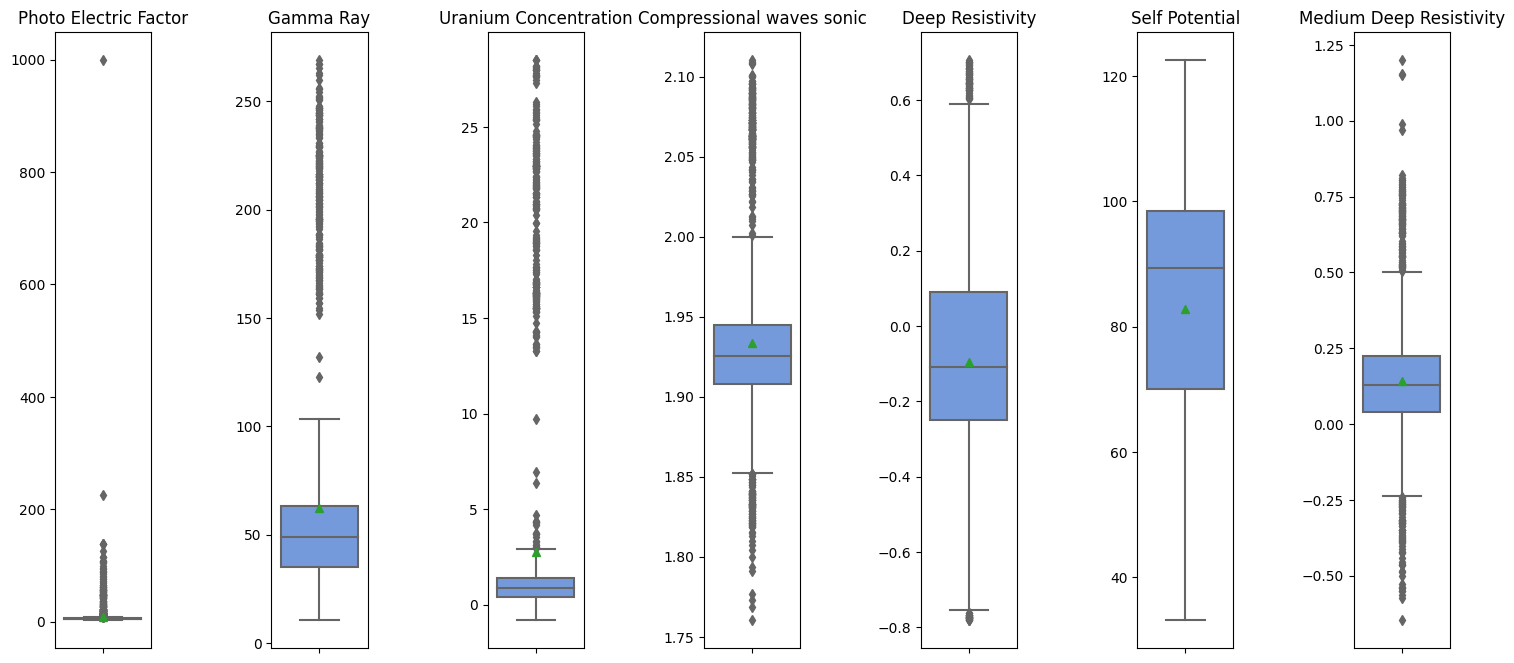

In [4]:
inputs = list(df.columns)
inputs.remove(My_Columns.LITHOLOGY)
total = len(inputs)
half = total // 2

# split inputs
inputs1 = inputs[:half]
inputs2 = inputs[half:total]
resistivity_to_log10(df)


fig, axs = plt.subplots(1, half, figsize=(18, 8))
for i, (ax, curve) in enumerate(zip(axs.flat, inputs1), 1):
    sns.boxplot(y=df[curve], ax=ax, color="cornflowerblue", showmeans=True)
    ax.set_title(inputs1[i - 1])
    ax.set_ylabel("")
plt.subplots_adjust(hspace=0.15, wspace=1.25)
plt.show()

fig, axs = plt.subplots(1, half, figsize=(18, 8))
for i, (ax, curve) in enumerate(zip(axs.flat, inputs2), 1):
    sns.boxplot(y=df[curve], ax=ax, color="cornflowerblue", showmeans=True)
    ax.set_title(inputs2[i - 1])
    ax.set_ylabel("")
plt.subplots_adjust(hspace=0.15, wspace=1.25)
plt.show()

We have too many outliers according to IQR, thus IQR is not a good method for detecting outliers in this case (as this is a multivariate distribution). Will try to find a better detection model


In [5]:
# calculate malahanobis distance
from sklearn.covariance import EmpiricalCovariance, MinCovDet
df_copy = df.copy()
df_copy.dropna(inplace=True)


# fit a Minimum Covariance Determinant (MCD) robust estimator to data
robust_cov = MinCovDet().fit(df)

# Get the Mahalanobis distance
m = robust_cov.mahalanobis(df)


In [6]:
df_copy.shape


(2393, 15)

In [7]:
# find outliers by IQR on mahalanobis distance
q1 = np.quantile(m, 0.25)
q3 = np.quantile(m, 0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
outliers = df_copy[m > upper_bound]
outliers = outliers.append(df_copy[m < lower_bound])
# non outliers are those in df_copy but not in outliers
non_outliers = df_copy[~df_copy.isin(outliers)].dropna()


In [8]:
len(outliers), len(non_outliers), len(df_copy)


(429, 1964, 2393)

In [9]:
# set a column to indicate if a row is an outlier
df["outlier"] = 0
df.loc[df.index.isin(outliers.index), "outlier"] = 1

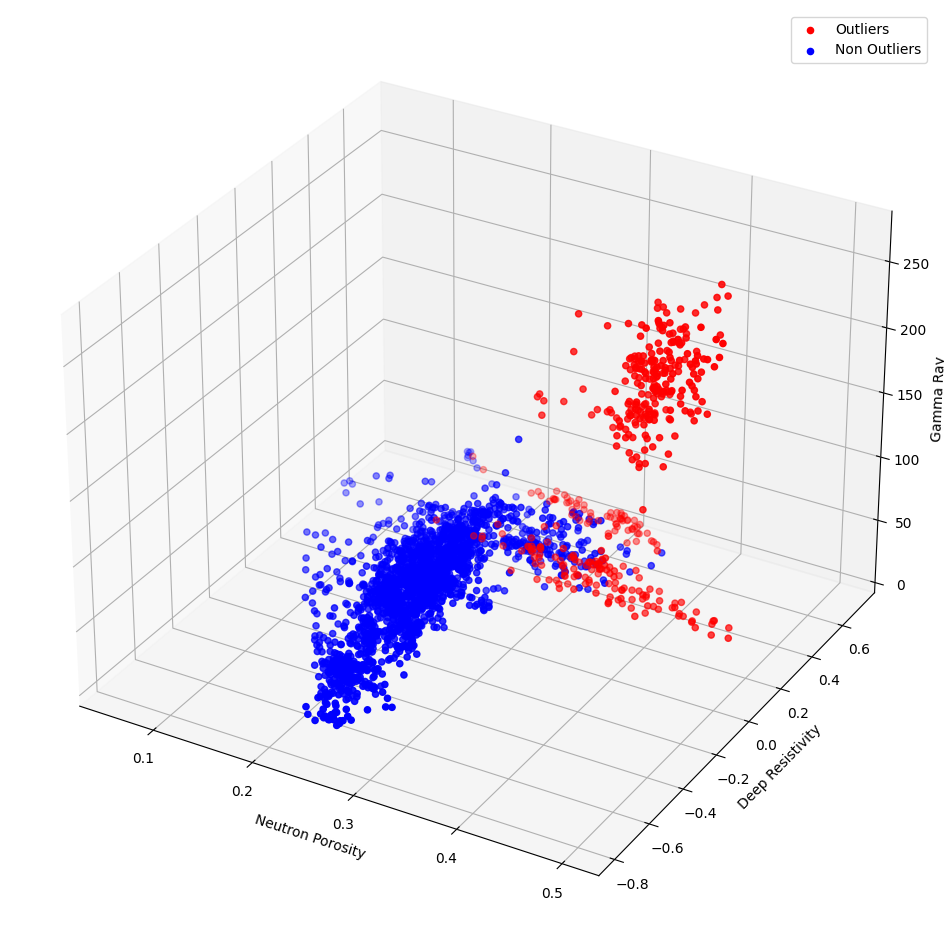

In [10]:
# plot the outliers neutron porosity, resistivity and gamma ray in a 3d scatter plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(outliers[My_Columns.NEUTRON_POROSITY], outliers[My_Columns.DEEP_RESISTIVITY], outliers[My_Columns.GAMMA_RAY], c='r', marker='o', label='Outliers')
ax.scatter(non_outliers[My_Columns.NEUTRON_POROSITY], non_outliers[My_Columns.DEEP_RESISTIVITY], non_outliers[My_Columns.GAMMA_RAY], c='b', marker='o', label='Non Outliers')
ax.set_xlabel(My_Columns.NEUTRON_POROSITY)
ax.set_ylabel(My_Columns.DEEP_RESISTIVITY)
ax.set_zlabel(My_Columns.GAMMA_RAY)
ax.legend()

In [11]:
def plot_outlier_points(A, B, outliers, non_outliers):
    # outliers = df[(df[A] > df[A].quantile(0.75)) | (df[A] < df[A].quantile(0.25))]
    # non_outliers = df[(df[A] < df[A].quantile(0.75)) & (df[A] > df[A].quantile(0.25))]
    try:
        plt.figure(figsize=(20, 10))
        sns.scatterplot(x=outliers[A], y=outliers[B], color="red")
        # mark the outliers on the plot
        sns.scatterplot(x=non_outliers[A], y=non_outliers[B], color="cornflowerblue")
        plt.title("Outliers in " + B + " vs " + A)
        plt.xlabel(A)
        plt.ylabel(B)
        plt.show()
    except Exception as e:
        print(e)

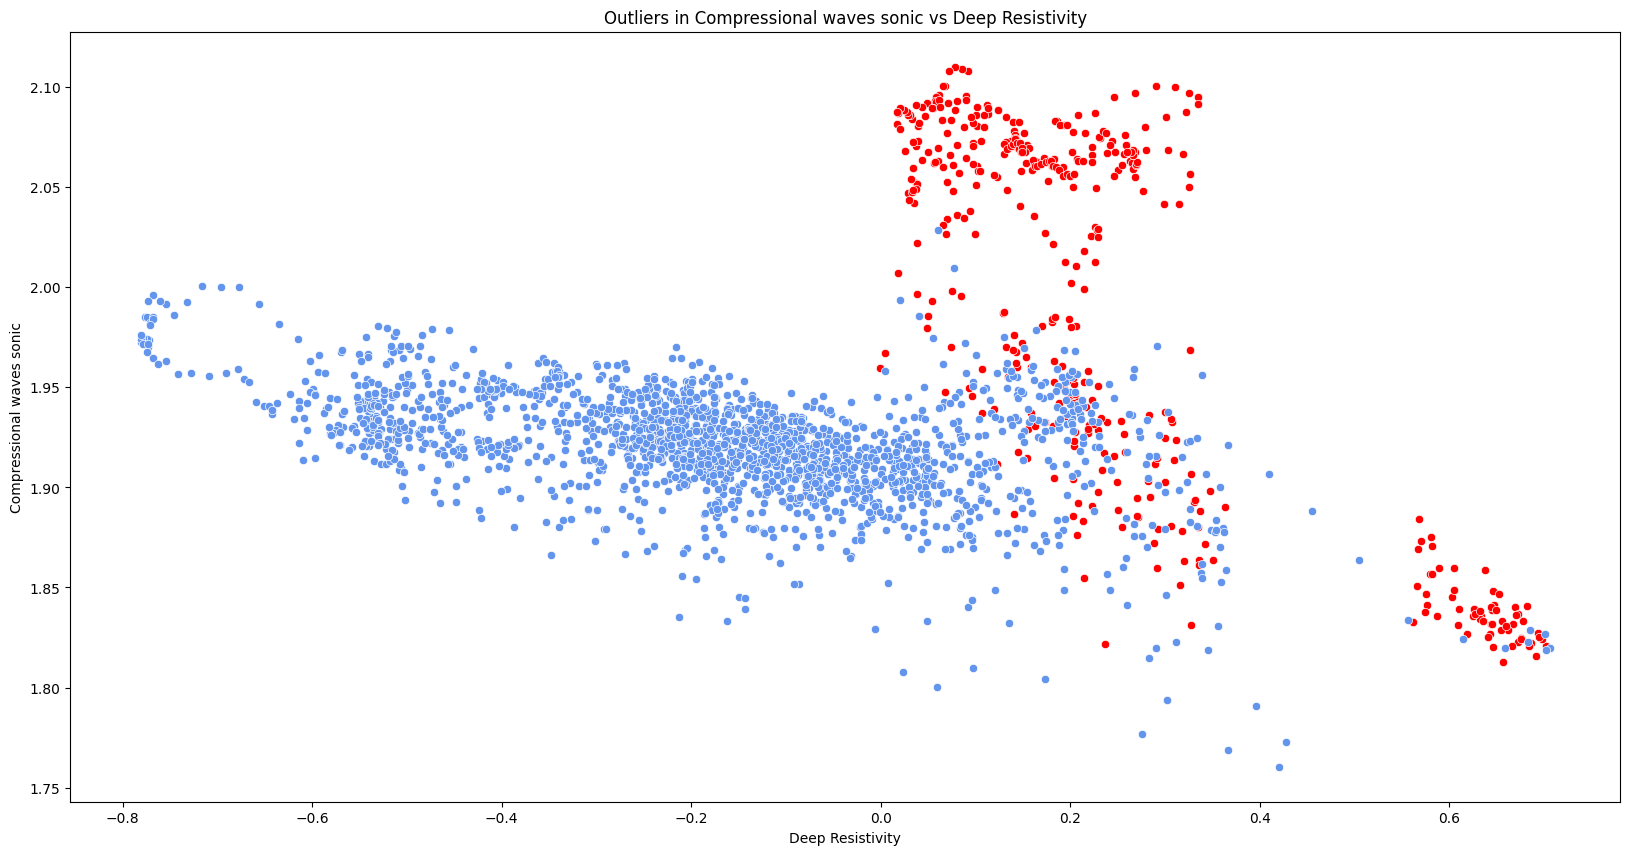

In [14]:
plot_outlier_points(My_Columns.DEEP_RESISTIVITY, My_Columns.COMPRESSIONAL_WAVES_SONIC,outliers, non_outliers)

Outliers have high resistivity -> better chance of being oil / gas

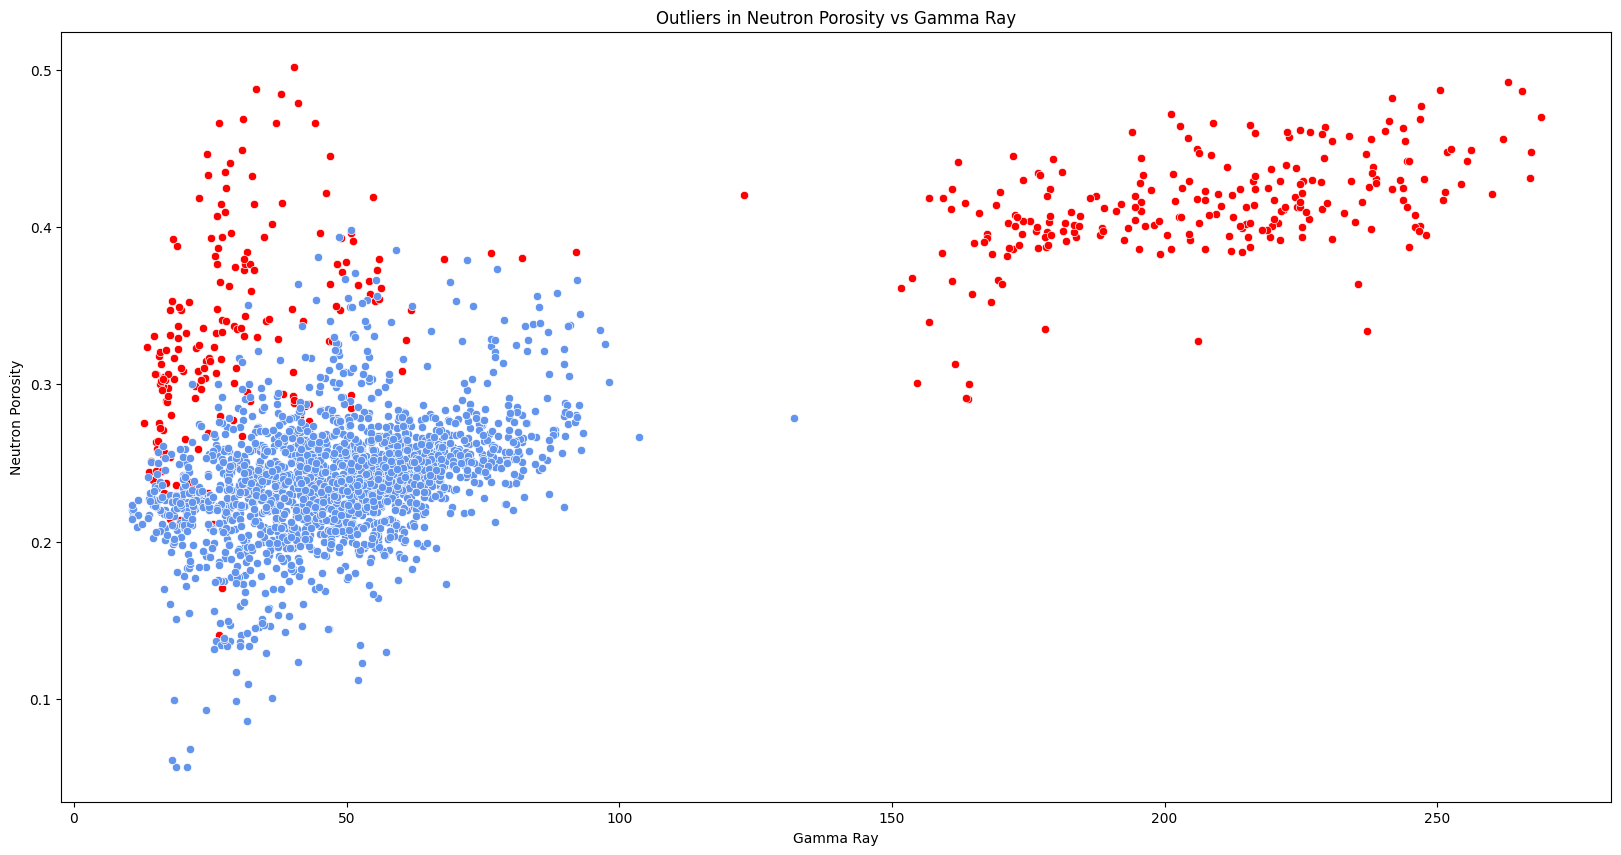

In [15]:
plot_outlier_points( My_Columns.GAMMA_RAY, My_Columns.NEUTRON_POROSITY, outliers, non_outliers)

Outliers have low gamma ray and high neutron porosity -> better chance of being oil / gas